# Lab 02: Linear-Quadratic Regulator

This lab looks into solving a Linear-Quadratic Regulator (LQR) problem
- Given the dynamics (model) $x_{t+1} = Ax_t + Bu_t$ of the state $x_t$ at each time $t$, the initial state $x^\text{init}$, and the time-horizon $T$, choose inputs $u_1, ..., u_{T-1}$, so that you minimize energy while driving state to the origin. Roughly speeking:
    - A state $x$ shall be small i.e. we get good regulation or control.
    - An input $u$ shall be small i.e. using small input effort or actuator force.
- In mathematic notation:

  $$\begin{aligned}
  \text{minimize}&\;\;\; \sum^{T}_{t=2} x_t^\top Q x_t + \sum^{T-1}_{t=1} u_t^\top R u_t \\
  \text{subject to}&\;\;\; x_1 = x^\text{init}, \;\; x_{t+1} = Ax_t + Bu_t, \;\; t = 1, ..., T-1
  \end{aligned}$$


- The objective is minimized for $x = 0$, some desired (equilibrium/target) state, and no input $u = 0$.
- Assumptions: $Q$ and $R$ are symmetric and positively-defined, $Q \succ 0, R \succ 0$.

We will look at it from three different perspectives:
1. LQR can be formulated and solved as the linearly constrained least-squares problem.
2. Dynamic programming gives an efficient, recursive method to solve the LQR problem.
3. The generic optimal control problem can be solved by iteratively approximating it as the LQR problem (iterative LQR or iLQR) <- **Challange!**

The point is to give you a taste of differentiable classical control methods.

## A vehicle moving in a plane

Our toy problem will be a vehicle moving in a plane
- Discretize the system at times $\tau = 0, h, 2h, ...$
- The state is 4D-vector $x_t = (p_t, v_t)$, where 2D-vectors $p_t$ and $v_t$ are the position and the velocity at time $ht$.
- The input is 2D-vector $u_t$ representing the applied force on the vehicle at time $ht$.
- The friction force is $- \eta v_t$ and the vehicle mass is $m$.

From classical mechanics, for small $h$, we have

$$\begin{align}
F_R = - \eta v_t + u_t \approx m\frac{v_{t+1} - v_t}{h}, &&
v_t \approx \frac{p_{t+1} - p_t}{h}
\end{align}$$

which we transform to get the approximate state update

$$\begin{align}
v_{t+1} = (1 - h\frac{\eta}{m})v_t + \frac{h}{m}u_t, &&
p_{t+1} = p_t + hv_t
\end{align}$$

Dynamics are $x_{t+1} = Ax_t + Bu_t$, where

$$\begin{align}
A = \begin{bmatrix}
1 & 0 & h & 0 \\
0 & 1 & 0 & h \\
0 & 0 & 1 - h\frac{\eta}{m} & 0 \\
0 & 0 & 0 & 1 - h\frac{\eta}{m}
\end{bmatrix}, &&
B = \begin{bmatrix}
0 & 0 \\
0 & 0 \\
\frac{h}{m} & 0 \\
0 & \frac{h}{m}
\end{bmatrix}
\end{align}$$

## 1. LQR as a linearly constrained least-squares problem

We define the quadratic objective with the linear constrains and ask CVXPY, the convex optimization package for Python, to solve it for us.

In [7]:
!pip install cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# Define the problem

T = 100
h = 0.1
eta = 0.1
mass = 1.0

A = np.array([[1, 0,       h,      0      ],
              [0, 1,       0,      h      ],
	          [0, 0, 1-h*eta/mass, 0      ],
	          [0, 0,       0, 1-h*eta/mass]])
B = np.array([[   0,      0  ],
              [   0,      0  ],
	          [h/mass,    0  ],
	          [   0,   h/mass]])
n, m = B.shape

x_init = np.array([10, 10, 10, -5]) # init. position (x=10, y=10), init. velocity (x=10, y=-5)

x = cp.Variable((T, n))
u = cp.Variable((T-1, m))

# Set the constrains

constraints = []
for t in range(0, T-1):
    constraints += [x[t+1, ...] == A @ x[t, ...] + B @ u[t, ...]]
constraints += [x[0, ...] == x_init]

In [35]:
# Set the objective

Q = np.eye(n)
Q[2,2] = 0
Q[3,3] = 0
R = np.eye(m) * 0.

objective = cp.Minimize(cp.sum(
    [cp.quad_form(x[t+1, :], Q) + cp.quad_form(u[t, :], R)
        for t in range(0, T-1)]
))

# Solve the problem

prob = cp.Problem(objective, constraints)
result = prob.solve()

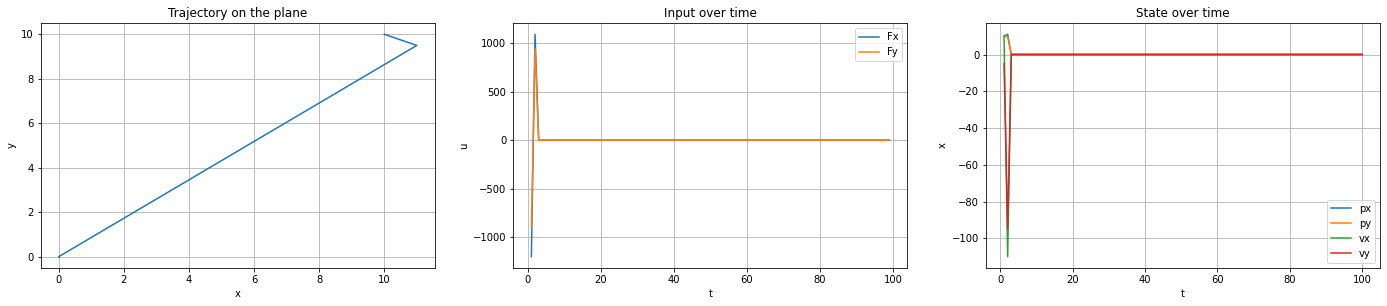

In [36]:
# Plot the result

nrows, ncols = 1, 3
dx, dy = 16, 9
scale = 1.5
figsize = plt.figaspect(float(dy * nrows) / float(dx * ncols)) * scale
plt.figure(figsize=figsize)

plt.subplot(nrows, ncols, 1)

px, py = x.value[..., 0], x.value[..., 1]
plt.plot(px, py)
plt.title('Trajectory on the plane')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

plt.subplot(nrows, ncols, 2)

plt.plot(np.arange(1, T), u.value[..., 0], label='Fx')
plt.plot(np.arange(1, T), u.value[..., 1], label='Fy')
plt.title('Input over time')
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.grid()

plt.subplot(nrows, ncols, 3)

plt.plot(np.arange(1, T+1), x.value[..., 0], label='px')
plt.plot(np.arange(1, T+1), x.value[..., 1], label='py')
plt.plot(np.arange(1, T+1), x.value[..., 2], label='vx')
plt.plot(np.arange(1, T+1), x.value[..., 3], label='vy')
plt.title('State over time')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()

plt.show()

### Exercise

Guess the answers and check them experimentally

1. Whan happens when you penalize speeding?
    <sub><sup><sub><sup><sub>
    Hint: Play with the velocity penalty $Q_v$.
    </sup></sub></sup></sub></sup>

    > Answer: If the speeding penalty is high then the car will move slowly, which may result in not reaching the destination in the allotted time.

1. What happens when you lift the speed penalty?

    > Answer: It tries to reduce the distance immediately and in the result it overshoots the target.

1. How can you accomplish the same effects by modifying the position penalty?

    > Answer: We can get the same effects by doing opposite operations with position penalty

1. What happens when you heavier penelize the energy use?
    <sub><sup><sub><sup><sub>
    Hint: Play with the input penalty $R$.
    </sup></sub></sup></sub></sup>

    > Answer: The force used has a lower value, making the vehicle move in a curve

1. What happens when you lift the energy use penalty?

    > Answer: At first the force is very strong, and then the vehicle is quickly slowed down (if the speed is penalized) and slowly rolls to the zero point

1. What is the time complexity of this method?

    > Answer: $O(n^3)$

$.$

## 2. Dynamic programming solution to the LQR problem

Recap LQR problem

$$\begin{aligned}
\text{minimize}&\;\;\; \sum^{T}_{t=2} x_t^\top Q x_t + \sum^{T-1}_{t=1} u_t^\top R u_t \\
\text{subject to}&\;\;\; x_1 = x^\text{init}, \;\; x_{t+1} = Ax_t + Bu_t, \;\; t = 1, ..., T-1
\end{aligned}$$

LQR Value Iteration

1. Set $P_0 = 0$
1. For $i = 1, ..., T$

  $$\begin{aligned}
  K_i &= -(R + B^\top P_{i-1} B)^{-1} B^\top P_{i-1} A \\
  P_i &= Q + K_i^\top R K_i + (A + BK_i)^\top P_{i-1}(A + BK_i)
  \end{aligned}$$

1. The optimal input (for the time-horizon T) is given by

  $$\begin{aligned}
  & u_t = K_Tx_t \\
  \text{for}\;\; & x_1 = x^\text{init}, \;\; x_{t+1} = Ax_t + Bu_t, \;\; t = 1, ..., T-1
  \end{aligned}$$

1. The cost-to-go (value) function is given by

  $$J_T(x) = x^\top P_T x$$

In [37]:
# (Re)define the vehicle problem

T = 100
h = 0.1
eta = 0.1
mass = 1.0

A = np.array([[1, 0,       h,      0      ],
              [0, 1,       0,      h      ],
	          [0, 0, 1-h*eta/mass, 0      ],
	          [0, 0,       0, 1-h*eta/mass]])
B = np.array([[   0,      0  ],
              [   0,      0  ],
	          [h/mass,    0  ],
	          [   0,   h/mass]])
n, m = B.shape

Q = np.eye(n)
R = np.eye(m)

x_init = np.array([10, 10, 10, -5]) # init. position (x=10, y=10), init. velocity (x=10, y=-5)

In [47]:
from numpy.linalg import inv

# Solve the problem

x = np.zeros((T, n))
u = np.zeros((T-1, m))

# Exercise: Implement the LQR Value Iteration algoritm

# Matrix (M) and vector (v) operations to use
#   - `inv(M)` matrix inversion.
#   - `M.T` or `v.T` vectors and matrix transposition.
#   - `M @ K` or `M @ v` mat-mat and mat-vec multiplication.

# Answer:
P = np.zeros((n,n))
for i in range(T):
  K = -inv(R+B.T@P@B)@B.T@P@A
  P = Q+K.T@R@K+(A+B@K).T@P@(A+B@K)
x[0] = x_init
for i in range(T-1):
  u[i] = K@x[i]
  x[i+1] = A@x[i]+B@u[i]

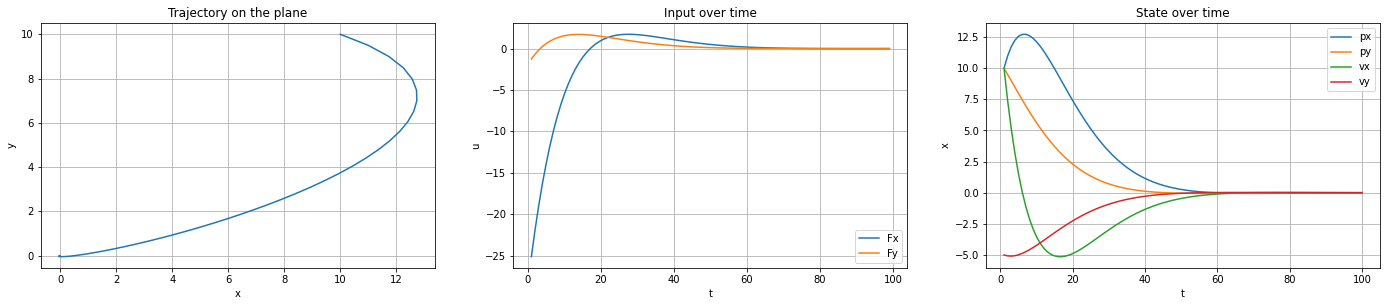

In [48]:
# Plot the result

nrows, ncols = 1, 3
dx, dy = 16, 9
scale = 1.5
figsize = plt.figaspect(float(dy * nrows) / float(dx * ncols)) * scale
plt.figure(figsize=figsize)

plt.subplot(nrows, ncols, 1)

px, py = x[..., 0], x[..., 1]
plt.plot(px, py)
plt.title('Trajectory on the plane')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

plt.subplot(nrows, ncols, 2)

plt.plot(np.arange(1, T), u[..., 0], label='Fx')
plt.plot(np.arange(1, T), u[..., 1], label='Fy')
plt.title('Input over time')
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.grid()

plt.subplot(nrows, ncols, 3)

plt.plot(np.arange(1, T+1), x[..., 0], label='px')
plt.plot(np.arange(1, T+1), x[..., 1], label='py')
plt.plot(np.arange(1, T+1), x[..., 2], label='vx')
plt.plot(np.arange(1, T+1), x[..., 3], label='vy')
plt.title('State over time')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()

plt.show()

### Exercise

Answer the questions

1. How to modify the algorithm to the infinite time-horizon case?

    > Answer: You have to wait until convergence

1. What is the time complexity of this method?

    > Answer: $O(Tn^3)$

1. How you apply LQR to non-linear problems?

    > Answer: You can linearize problem around some fixed points and use it when the initial state is not far from them.

$.$

## 3. The generic optimal control problem

Iterative Linear Quadratic Regulator (iLQR) iteratively linearize the non-linear problem and solves it with e.g. LQR Value Iteration.

1. Initialize input $u^{(0)}_1, ..., u^{(0)}_T$ and $i = 0$
1. Execute the current input and record the resulting state-input trajectory $x^{(i)}_1, u^{(i)}_1, ..., x^{(i)}_T, u^{(i)}_T$
1. Linearize (first-order Taylor expansion) the dynamics, $x_{t+1} = f(x_t, u_t)$, around $(x^{(i)}_t, u^{(i)}_t)$

  $$x_{t+1} = f(x^{(i)}_t, u^{(i)}_t) + \frac{\partial f}{\partial x}(x^{(i)}_t, u^{(i)}_t)(x_t - x^{(i)}_t) + \frac{\partial f}{\partial u}(x^{(i)}_t, u^{(i)}_t)(u_t - u^{(i)}_t)$$

  Substracting $x^{(i)}_{t+1}$ on both sides

  $$x_{t+1} - x^{(i)}_{t+1} = f(x^{(i)}_t, u^{(i)}_t) - x^{(i)}_{t+1} + \frac{\partial f}{\partial x}(x^{(i)}_t, u^{(i)}_t)(x_t - x^{(i)}_t) + \frac{\partial f}{\partial u}(x^{(i)}_t, u^{(i)}_t)(u_t - u^{(i)}_t)$$

  Yields the standard Linear Time-Varying (LTV) format, $z_{t+1} = A_tz_t + B_tv_t$, where

  $$\begin{aligned}
  z_t &= \begin{bmatrix}
  x_t - x^{(i)}_t & 1
  \end{bmatrix}^\top \\
  v_t &= (u_t - u^{(i)}_t) \\
  A_t &= \begin{bmatrix}
  \frac{\partial f}{\partial x}(x^{(i)}_t, u^{(i)}_t) & f(x^{(i)}_t, u^{(i)}_t) - x^{(i)}_{t+1} \\
  0 & 1
  \end{bmatrix} \\
  B_t &= \begin{bmatrix}
  \frac{\partial f}{\partial u}(x^{(i)}_t, u^{(i)}_t) \\
  0
  \end{bmatrix}
  \end{aligned}$$

1. Similarly, approximate (second-order Taylor expansion) the cost $g(x_t, u_t)$ to give the quadratic form $g(z_t, v_t) = z^\top_t Q_t z_t + v_t^\top R_t v_t$
  
  $$\begin{aligned}
  Q_t &= \begin{bmatrix}
  \frac{1}{2} \frac{\partial^2 g}{\partial x^2}(x^{(i)}_t, u^{(i)}_t) & 0 \\
  \frac{\partial g}{\partial x}(x^{(i)}_t, u^{(i)}_t) + [u_t - u^{(i)}_t]\frac{\partial^2 g}{\partial u \partial x}(x^{(i)}_t, u^{(i)}_t) & g(x^{(i)}_t, u^{(i)}_t) + \frac{\partial g}{\partial u}(x^{(i)}_t, u^{(i)}_t)[u_t - u^{(i)}_t]
  \end{bmatrix} \\
  R_t &= \left( \frac{1}{2} \frac{\partial^2 g}{\partial u^2}(x^{(i)}_t, u^{(i)}_t) \right)
  \end{aligned}$$

1. Solve the resulting LQR LTV problem for the optimal (at iteration $i+1$) input $u^{(i+1)}_1, ..., u^{(i+1)}_T$
1. Increment $i = i + 1$ and go to step 2.

### Challenge

The first student to implement it to solve the [CartPole Swing-Up](https://coneural.org/florian/papers/05_cart_pole.pdf) problem (code below) gets half the final grade up! The problem is solved, when the pole from the downwards position at the centre is put in the upward position at the centre and stays there.

![CartPole Swing-Up](https://github.com/Shunichi09/PythonLinearNonlinearControl/raw/master/assets/cartpole.gif)

**Links**
- [DDP iLQR paper](https://homes.cs.washington.edu/~todorov/papers/TassaICRA14.pdf)
- [Original iLQR paper](https://homes.cs.washington.edu/~todorov/papers/LiICINCO04.pdf)
- [iLQR implementation](https://github.com/studywolf/control/blob/master/studywolf_control/controllers/ilqr.py)
- [Blog post backing the implementation](https://studywolf.wordpress.com/2016/02/03/the-iterative-linear-quadratic-regulator-method/)

In [ ]:
!pip install scikit-video

     |████████████████████████████████| 2.3 MB 5.2 MB/s 


In [ ]:
import math

import cv2
import numpy as np
import skvideo.io
import tensorflow as tf

from base64 import b64encode
from IPython.display import HTML

def show_video(file_name):
    mp4 = open(file_name,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=480 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

In [ ]:
# Define the problem

class CartPole:
    def __init__(self, dt,
                 mc=1.0,
                 mp=0.1,
                 l=1.0,
                 g=9.80665):
        """CartPole problem.

        Args:
            dt: Time step [s].
            mc: Cart mass [kg].
            mp: Pendulum mass [kg].
            l: Pendulum length [m].
            g: Gravity acceleration [m/s^2].

        Note:
            state x: [px, px', theta, theta'].
            input u: [Fx], it's bound to (-1, 1) in `step`.
            theta: 0 is pointing up and increasing clockwise.
        """

        self.dt = dt
        self.mc = mc
        self.mp = mp
        self.l = l
        self.g = g

        self.action_dim = 1
        self.state_dim = 4
        self.pi = tf.constant(math.pi)

    def step(self, x, u):
        """Calculates the next state."""
        x_ = x[..., 0]
        x_dot = x[..., 1]
        theta = x[..., 2]
        sin_theta = tf.sin(theta)
        cos_theta = tf.cos(theta)
        theta_dot = x[..., 3]
        F = tf.tanh(u[..., 0])

        # Define frictionless dynamics as per (Razvan V. Florian, 2007)
        # Paper: https://coneural.org/florian/papers/05_cart_pole.pdf

        # Eq. 23
        temp = (F + self.mp * self.l * theta_dot**2 * sin_theta) / (self.mc + self.mp)
        numerator = self.g * sin_theta - cos_theta * temp
        denominator = self.l * (4.0 / 3.0 - self.mp * cos_theta**2 / (self.mc + self.mp))
        theta_dot_dot = numerator / denominator

        # Eq. 24
        x_dot_dot = temp - self.mp * self.l * theta_dot_dot * cos_theta / (self.mc + self.mp)

        return tf.transpose(tf.stack([
            x_ + x_dot * self.dt,
            x_dot + x_dot_dot * self.dt,
            theta + theta_dot * self.dt,
            theta_dot + theta_dot_dot * self.dt,
        ]))

    def cost(self, x, u):
        """Calculates the state-input cost."""
        x_ = x[..., 0]
        x_dot = x[..., 1]
        # Shift by pi so zero angle, and hence the cost, is the up position
        cos_theta = tf.cos(x[..., 2] + self.pi)
        theta_dot = x[..., 3]

        # Note: There is no penalty for the input
        #       However, it's bounded to (-1, 1) in `step`
        g = 6 * x_**2 + 12 * (1 + cos_theta)**2 + 0.1 * x_dot**2 + 0.1 * theta_dot**2
        return g * self.dt

    def render(self, x_history, file_name='cartpole.mp4'):
        """Renders the whole trajectory to the mp4 file."""
        frames = []
        for x in x_history:
            frames.append(self._render_state(x))
        skvideo.io.vwrite(file_name, np.stack(frames))

    def _render_state(self, x):
        """Renders one frame."""
        screen_width = 640
        screen_height = 480
        world_width = 2 * 2.4
        scale = screen_width / world_width
        cart_y = screen_height - 100
        pole_width = 10
        pole_len = scale * self.l
        cart_width = 50
        cart_height = 30


        # Get the cart position and the pole angle
        position, _, angle, _ = x
        cart_x = int(position * scale + screen_width / 2.0)

        # Prepare a blank image of screen size
        img = np.ones((screen_height, screen_width, 3)) * 255.

        # Draw a rail
        img = cv2.line(
            img,
            pt1=(0, cart_y),
            pt2=(screen_width, cart_y),
            color=(0, 0, 0)
        )

        # Draw a cart
        img = cv2.rectangle(
            img,
            pt1=(cart_x - cart_width // 2,
                    cart_y - cart_height // 2),
            pt2=(cart_x + cart_width // 2,
                    cart_y + cart_height // 2),
            color=(0, 0, 0),
            thickness=cv2.FILLED
        )

        # Draw a pole
        img = cv2.line(
            img,
            pt1=(cart_x, cart_y),
            pt2=(int(cart_x + pole_len * np.sin(angle)),
                    int(cart_y - pole_len * np.cos(angle))),
            color=(204, 153, 102),
            thickness=pole_width
        )

        # Draw an axle
        img = cv2.circle(
            img,
            center=(cart_x, cart_y),
            radius=pole_width // 2,
            color=(127, 127, 204),
            thickness=cv2.FILLED
        )

        return img.astype(np.uint8)

In [ ]:
cartpole = CartPole(dt=0.05)
x0 = tf.constant([0, 0, math.pi / 4, 0], dtype=tf.float32)
u = tf.zeros((T, cartpole.action_dim))

trajectory = [x0]
for i in range(T-1):
    trajectory.append(cartpole.step(trajectory[-1], u[i]))
x = tf.stack(trajectory)

print("Total cost: ", tf.reduce_sum(cartpole.cost(x, u)))

Total cost:  tf.Tensor(73.19609, shape=(), dtype=float32)


In [ ]:
file_name="./video.mp4"
cartpole.render(x.numpy(), file_name)
show_video(file_name)